In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
from torch.autograd import Variable

In [2]:
class RNN(nn.Module):
    def __init__(self, in_no, hid_no, layer_no, device):
        super(RNN, self).__init__()
        
        self.in_no = in_no
        self.hid_no = hid_no
        self.layer_no = layer_no
        self.device = device
        
        self.rnn = nn.RNN(in_no, hid_no, layer_no, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hid_no, 1)
        
        self.Tau = nn.Parameter(torch.ones(self.in_no)*0.5, requires_grad=False)
        self.W = nn.Parameter(torch.ones(self.in_no)*0, requires_grad=True)
                
    def forward(self, S):
        T_data = S.shape[0]
        
        t = torch.arange(101).reshape(1,-1).repeat(self.in_no,1).to(self.device)
        t_tau = t / torch.exp(self.Tau).reshape(-1,1)
        kern = t_tau * torch.exp(-t_tau)
        #kern = t_tau * torch.exp(-t_tau)
        kern = torch.flip(kern, [1]).unsqueeze(1)
        
        S_conv = F.conv1d(S.T.unsqueeze(0), kern, groups=self.in_no, padding=50).squeeze(0).T
        S_conv = S_conv.unsqueeze(1)
        
        #S_conv = S.unsqueeze(1)
        
        h0 = Variable(torch.zeros(self.layer_no, T_data, self.hid_no).to(self.device))
        out, hn = self.rnn(S_conv, h0)
        V_raw = self.fc(out[:,-1,:]).flatten()
        V = F.softplus(V_raw)
        
        return V


In [3]:
eloc = np.load("/media/hdd01/sklee/CA1_clust4-60/data/Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep10_stimseed1.npy")
den_idx = np.unique(eloc[880:1120,0])
syn_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]

C_syn_e = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub5_C_syn_e.npy")
C_syn_e = torch.from_numpy(C_syn_e)[1:]

In [4]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
#I_neural_file = "Ispikes_neural.npy"
V_file = "V_diff.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)[:,:]
#I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)

E_neural = torch.from_numpy(E_neural)
E_neural = torch.matmul(E_neural, C_syn_e.T)

#I_neural = torch.from_numpy(I_neural)
V = torch.from_numpy(V)

#####
V[V < 0.3] = 0

In [5]:
T_train = 8 * 1000 * 50
T_test = 1 * 1000 * 50
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")
hid_no = 7
layer_no = 3
in_no = 4

batch_size = 25000
iter_no = 10000
epoch_no = iter_no*batch_size//T_train 


In [6]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
#test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
#train_I_neural = I_neural[:T_train].float()

part_V_train = V_train[:50000].to(device)
part_train_E_neural = train_E_neural[:50000].to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    #part_idx = np.arange(T_train - batch_size)
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [7]:
model = RNN(in_no, hid_no, layer_no, device)

#optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

327


In [8]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    #batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred = model(batch_E_neural)
        
    mse = torch.mean((V_pred - batch_V)**2)
    var = torch.var(V_pred - batch_V)
    
    reg2 = 0
    reg1 = 0
    for param in model.parameters():
        reg2 += torch.sum(param**2)
        reg1 += torch.sum(torch.abs(param))
    
    loss = mse
    
    loss.backward()
    optimizer.step()
    
    if i%100 == 99:
        model.eval()
        test_V_pred = model(test_E_neural) 
        train_V_pred = model(part_train_E_neural)
         
        test_mse = torch.mean((test_V_pred - V_test)**2).item()
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        
        train_mse = torch.mean((train_V_pred - part_V_train)**2).item()
        train_score = explained_variance_score(part_V_train.cpu().detach().numpy(), train_V_pred.cpu().detach().numpy())
        
        tau_avg = torch.mean(model.Tau).item()
        W_avg = torch.mean(model.W).item()
        
        print(i, np.round(test_score, 6),
              np.round(test_mse, 6),
              np.round(train_score, 6),
              np.round(train_mse, 6),
              np.round(tau_avg, 6),
              np.round(W_avg, 6)
              
              #torch.sum(test_Z_pred).item(),
             #model.W_out.item(),
             #model.Tau_out.item()
             )


<ipython-input-8-fb8f1589fed3>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


99 -0.000624 0.025438 -0.000502 0.032526 0.5 0.0
199 -0.000331 0.022656 -0.000265 0.029862 0.5 0.0
299 -0.000225 0.021959 -0.000179 0.029214 0.5 0.0
399 -0.000169 0.021683 -0.000133 0.028966 0.5 0.0
499 -0.000134 0.021556 -0.000105 0.028857 0.5 0.0
599 -0.00011 0.021489 -8.6e-05 0.028802 0.5 0.0
699 -9.2e-05 0.02145 -7.1e-05 0.028773 0.5 0.0
799 -7.7e-05 0.021428 -5.9e-05 0.028757 0.5 0.0
899 -6.5e-05 0.021415 -4.9e-05 0.028749 0.5 0.0
999 -5.4e-05 0.021406 -3.9e-05 0.028744 0.5 0.0
1099 -4.4e-05 0.0214 -3.1e-05 0.028742 0.5 0.0
1199 -3.3e-05 0.021397 -2.2e-05 0.02874 0.5 0.0
1299 -2.2e-05 0.021394 -1.2e-05 0.02874 0.5 0.0
1399 -1e-05 0.021393 -2e-06 0.02874 0.5 0.0
1499 3e-06 0.021392 1e-05 0.028739 0.5 0.0
1599 1.8e-05 0.021391 2.3e-05 0.02874 0.5 0.0
1699 3.7e-05 0.02139 3.9e-05 0.02874 0.5 0.0
1799 6.2e-05 0.021389 6.1e-05 0.028739 0.5 0.0
1899 9.7e-05 0.021388 9.1e-05 0.028738 0.5 0.0
1999 0.000148 0.021387 0.000135 0.028738 0.5 0.0
2099 0.000254 0.021385 0.000223 0.028735 0.5 0.0

KeyboardInterrupt: 

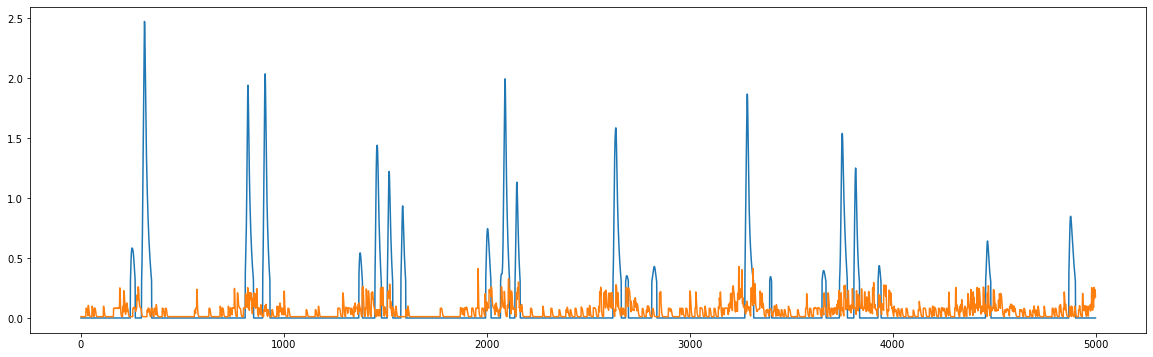

In [9]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[15000:30000][3000:8000])
plt.plot(test_V_pred.cpu().detach().numpy()[15000:30000][3000:8000])


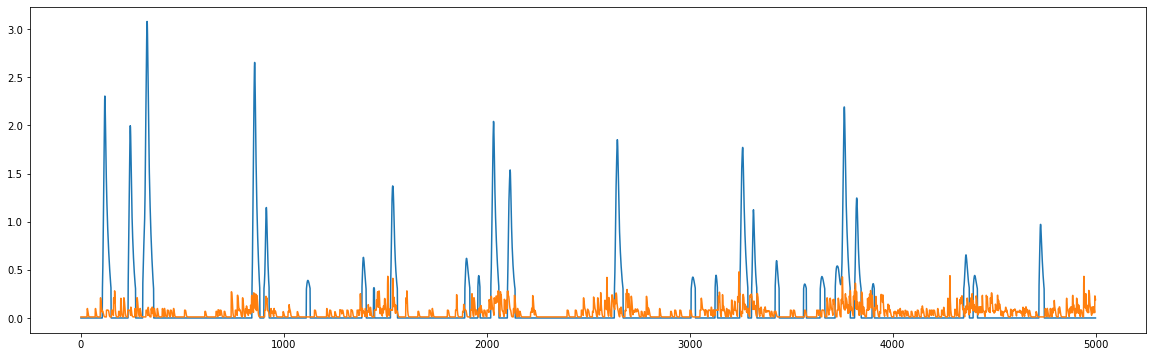

In [10]:
plt.figure(figsize=(20,6))
plt.plot(part_V_train.cpu().detach().numpy()[15000:30000][3000:8000])
plt.plot(train_V_pred.cpu().detach().numpy()[15000:30000][3000:8000])